In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import swiftsimio as sw
from swiftsimio.objects import InvalidConversionError
import unyt

# Simulation directory structure

Before we start looking at the data let's take a quick look at how everything is stored.

All simulations are kept at `/cosma8/data/dp004/colibre/Runs`. Here you will see a collection of directories with names of the form `LXXXXNYYYY`. The value of `XXXX` corresponds to the simulation box side length in comoving Mpc, and the value of `YYYY` is the number of gas particles per linear dimension. Each simulation has four times as many dark matter particles as gas. We will use one of the `L0025N0376` simulations, meaning they have a volume of $(25\mathrm{Mpc})^3$, $376^3$ gas particles, and $4 \times 376^3$ dark matter particles.

For each box size and resolution we have a multiple simulations. Each of these has a different set of subgrid models (the way we include physical processes in the simulation, e.g. black hole feedback). For this notebook we will use the `Fiducial_test` simulation.

Let's list what's present inside the simulation directory:

In [2]:
!ls /cosma8/data/dp004/colibre/Runs/L0025N0376/Fiducial_test

colibre_L025N0376.yml	 pipeline_output	  SNII.txt
colibre.xmf		 rank_cpu_balance.log	  SOAP
data_0123.yml		 rank_hostname.log	  statistics.txt
dependency_graph_-1.csv  rank_memory_balance.log  submit.slurm
HBTplus			 resub.sh		  swift-colibre
logs			 resub.slurm		  task_level_0000_-1.txt
output_fields.yml	 r_processes.txt	  timesteps.txt
output_list_ps.txt	 SFR.txt		  unused_parameters.yml
output_list.txt		 snapshots		  used_parameters
partition_fixed_costs.h  SNIa.txt


You probably don't won't ever need to look at most of these files. The most important files/directories (which we'll look at below) are:
- `snapshots` This directory contains the particles and their properties output by the simulation at different times
- `SOAP` This directory contains the halo catalogues
- `HBTplus` This directory contains the full halo merger tree information for the simulation
- `output_list.txt` This file lists the redshifts at which snapshots have been created

Let's print the first few lines of `output_list.txt` 

In [3]:
!head -5 /cosma8/data/dp004/colibre/Runs/L0025N0376/Fiducial_test/output_list.txt

# Redshift, Select Output
30.000000, Snapshot
25.000000, Snipshot
22.500000, Snipshot
20.000000, Snapshot


We can see that the first snapshot (`snap_nr=0` since the files are 0-indexed) corresponds to `z=30`. If we want the `z=20` snapshot we will need to load `snap_nr=3`.

For some redshifts we output all the particle properties. For others we output a reduced file with significantly less properties, which are called snipshots.

The `swiftsnap` command from swiftsimio is useful for viewing information about snapshot files. For information about it's usage see [the documentation.](https://swiftsimio.readthedocs.io/en/latest/command_line/index.html#swiftsnap). To use it you must be in a python environment with swiftsimio installed. 

# Snapshot datasets

Analysis of SWIFT snapshots should be carried out using [swiftsimio](https://swiftsimio.readthedocs.io/en/latest/index.html). This ensures that all units will be handled correctly (internal cosmological simulation units can be strange), and contains a lot of useful functionality for working with the files.


Within the `snapshots` directory there is a directory for each snapshot. Each of these contains a number of "chunk" files, named `colibre_xxxx.y.hdf5`. There is also a virtual file named `colibre_xxxx.hdf5`. **You should always load the virtual file rather than the chunk files**. Each chunk file only contains a subset of the total number of particles in the simulation, but if you use the virtual file you will have access to all the particles. Even if you only want to load a small region of the simulation you should use the virtual file combined with swiftsimio's masking ability (see below).

We begin by loading the `z=1` snapshot.

In [4]:
simulation_dir = "/cosma8/data/dp004/colibre/Runs/L0025N0376/Fiducial_test"
# For this test run we only had 124 snapshots, but all the main simulations have 128 snapshots, so double-check you have the correct snapshot.
snap_nr = 88
snapshot_filename = f"{simulation_dir}/snapshots/colibre_{snap_nr:04}/colibre_{snap_nr:04}.hdf5"
snap = sw.load(snapshot_filename)

### Metadata and loading particle properties

Basic information about the simulation can be accessed through the metadata attribute

In [5]:
print(f"Boxsize: {snap.metadata.boxsize}")
print(f"Redshift: {snap.metadata.redshift}")
print(f"Omega_lambda {snap.metadata.cosmology['Omega_cdm']}")
print(f"Number of gas particles: {snap.metadata.n_gas}")

Boxsize: [25.00000001 25.00000001 25.00000001] Mpc
Redshift: 1.0
Omega_lambda [0.256011]
Number of gas particles: 50971999


All the gas particle properties are contained within `snap.gas` (likewise for `snap.dark_matter`, `snap.stars`, `snap.black_holes`). For example the mass of the gas particles

In [6]:
print(snap.gas.masses)
print(snap.gas.masses.shape)

[0.00019066 0.00019555 0.00018962 ... 0.00018733 0.00019002 0.00018751] 10000000000.0*Msun (Comoving)
(50971999,)


You can find out what properties are available by using tab completion, or within the metadata. The property descriptions can also be accessed from the swiftsimio object.

In [7]:
print(snap.metadata.gas_properties.field_names[:3])
print(snap.gas.last_energies_received_from_agnfeedback.name)

['averaged_star_formation_rates', 'compton_yparameters', 'coordinates']
The energy the particles received the last time they were heated by AGN feedback. Not masked.


Each dataset has units associated with them that are automatically read in from the snapshot. Data is initially loaded in the simulation units, but it is easy to convert to your unit of choice.

**Specify the units you want, don't assume the datasets have the units you expect**

In [8]:
mass_msun = snap.gas.masses.to("Msun")
print(np.log10(mass_msun))

[6.280249  6.291265  6.2778854 ... 6.2726173 6.2788067 6.2730255]


Swiftsimio will automatically combine units for you, and will throw an error if you try and combine datasets in an inconsistent way

In [9]:
volume = snap.gas.masses / snap.gas.densities
print("Volume:", volume)

try:
    snap.gas.masses + snap.gas.densities
except ValueError:
    print("You can't combine those!")

Volume: [0.00295246 0.00265667 0.00187379 ... 0.0007878  0.0006287  0.00054782] Mpc**3 (Comoving)
You can't combine those!


Properties are stored as co-moving quantities. This means you may need to convert them to physical depending on your use case

In [10]:
print("Comoving positions")
snap.gas.coordinates[:10]

Comoving positions


cosmo_array([[0.2611892, 0.0491192, 7.8849302],
       [0.1353292, 0.0343112, 8.1291142],
       [0.2246172, 0.3370582, 8.1658752],
       [0.0839512, 0.2286102, 8.1874442],
       [0.2007642, 0.3070582, 8.0156952],
       [0.1674202, 0.2194162, 8.0857712],
       [0.3428662, 0.2435992, 8.1275442],
       [0.1757712, 0.2412162, 7.8746612],
       [0.2978952, 0.1163872, 8.0569282],
       [0.0676302, 0.2984932, 8.1075112]], 'Mpc', comoving=True)

In [11]:
print("Physical positions")
snap.gas.coordinates[:10].to_physical()

Physical positions


cosmo_array([[0.1305946, 0.0245596, 3.9424651],
       [0.0676646, 0.0171556, 4.0645571],
       [0.1123086, 0.1685291, 4.0829376],
       [0.0419756, 0.1143051, 4.0937221],
       [0.1003821, 0.1535291, 4.0078476],
       [0.0837101, 0.1097081, 4.0428856],
       [0.1714331, 0.1217996, 4.0637721],
       [0.0878856, 0.1206081, 3.9373306],
       [0.1489476, 0.0581936, 4.0284641],
       [0.0338151, 0.1492466, 4.0537556]], 'Mpc', comoving=False)

Some properties (for which it does not make sense to refer to as comoving) cannot be converted. This can be checked with the `valid_transform` attribute.

In [12]:
print('Coordinates have valid transform?', snap.gas.coordinates.valid_transform)
print('Last feedback scales factors have valid transform?', snap.gas.last_agnfeedback_scale_factors.valid_transform)

try:
    snap.gas.last_agnfeedback_scale_factors.to_comoving()
except InvalidConversionError:
    print("You can't transform that!")

Coordinates have valid transform? True
Last feedback scales factors have valid transform? False
You can't transform that!


If you need a numpy array of the dataset, use `.value`

In [13]:
snap.gas.coordinates.value

array([[ 0.2611892 ,  0.0491192 ,  7.8849302 ],
       [ 0.1353292 ,  0.0343112 ,  8.1291142 ],
       [ 0.2246172 ,  0.3370582 ,  8.1658752 ],
       ...,
       [24.91037948, 24.90664348, 18.72689548],
       [24.81210748, 24.88645748, 18.65617348],
       [24.94263648, 24.98478748, 18.65686148]])

Certain properties have multiple columns, which you can access by specifying the name of the column you want

In [14]:
print(snap.stars.luminosities)
print(snap.stars.luminosities.GAMA_u)

Named columns instance with ['GAMA_u', 'GAMA_g', 'GAMA_r', 'GAMA_i', 'GAMA_z', 'GAMA_Y', 'GAMA_J', 'GAMA_H', 'GAMA_K'] available for "luminosities"
[4160. 3620. 3652. ... 3448. 7448. 4712.] dimensionless (Physical)


### Masking

SWIFT outputs files which are spatially sorted. This means it is possible to load the particles within a certain section of the simulation volume, rather than having to load everything. This can significantly reduce the time spent loading data.

Let's load the same snapshot as before, but only a small section of the box. Once loaded the object behaves the same as before.

In [15]:
snap = sw.load(snapshot_filename)
print(f"Number of gas particles in snapshot: {snap.gas.masses.shape[0]}")

mask = sw.mask(snapshot_filename)
boxsize = mask.metadata.boxsize

# Specify the region of the box we want to load (this requires units)
load_region = [[0.1 * b, 0.3 * b] for b in boxsize]
print('Load region:', load_region)

mask.constrain_spatial(load_region)
mask_snap = sw.load(snapshot_filename, mask=mask)
print(f"Number of gas particles in load region: {mask_snap.gas.masses.shape[0]}")

Number of gas particles in snapshot: 50971999
Load region: [[unyt_quantity(2.5, 'Mpc'), unyt_quantity(7.5, 'Mpc')], [unyt_quantity(2.5, 'Mpc'), unyt_quantity(7.5, 'Mpc')], [unyt_quantity(2.5, 'Mpc'), unyt_quantity(7.5, 'Mpc')]]
Number of gas particles in load reg: 410895


Let's look at the distribution of the particles.

Text(0, 0.5, 'PDF')

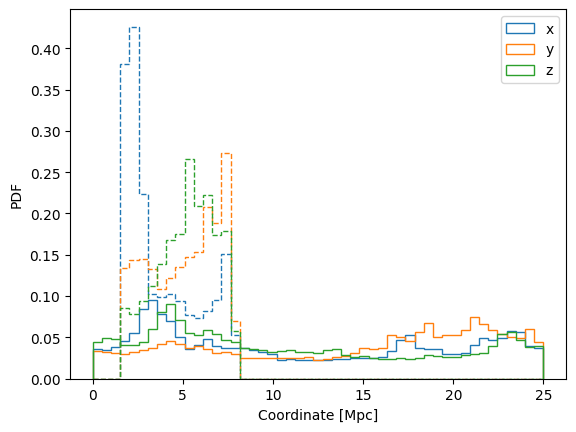

In [16]:
bins = np.linspace(0, 25, 50)
labels = ['x', 'y', 'z']
for i in range(3):
    plt.hist(snap.gas.coordinates[:, i].to('Mpc').value, bins=bins, histtype='step', density=True, color=f'C{i}', linestyle='-', label=labels[i])
    plt.hist(mask_snap.gas.coordinates[:, i].to('Mpc').value, bins=bins, histtype='step', density=True, color=f'C{i}', linestyle='--')
plt.legend()
plt.xlabel('Coordinate [Mpc]')
plt.ylabel('PDF')

This works because SWIFT groups particles into cells. Any cells that overlap with the load region specified will be loaded. This means that you will often end up loading some particles outside of the load region specified, so you need to apply your own mask if you don't want particles outside the load region. 

In [39]:
mask_snap.gas.coordinates.max()

cosmo_array(7.8124911, 'Mpc', comoving=True)

### Visualisation

Sometimes you may want to visualise a set of particles or specific region of the simulation in order to gain insight into what enviroment a galaxy exists in. [Swiftsimio supports multiple options for this](https://swiftsimio.readthedocs.io/en/latest/visualisation/index.html)

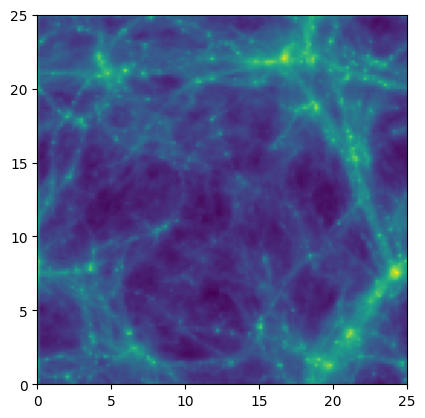

In [17]:
snap = sw.load(snapshot_filename)
boxsize = snap.metadata.boxsize[0].to('Mpc').value
extent = [0, boxsize, 0, boxsize]

mass_map = sw.visualisation.projection.project_gas(
    snap,
    resolution=128,
    project="masses",
    parallel=True,
    periodic=True,
)

mass_map = mass_map.to('Msun/kpc**2').value

plt.imshow(LogNorm()(mass_map), cmap="viridis", extent=extent)

# SOAP

Once the simulation has been completed we identify bound subhalo using [HBTplus](https://github.com/SWIFTSIM/HBTplus). The output of HBT is passed to [SOAP](https://github.com/SWIFTSIM/SOAP), which we use to calculate a wide range of halo/galaxy properties.

The properties available in SOAP vary depending on the simulation, and within the `SOAP` directory of each simulation there is a `SOAP.pdf` file which is generated from the SOAP parameter file of that run. An example of pdf, which gives a summary of what information is available in SOAP, can be found [here](https://ftp.strw.leidenuniv.nl/mcgibbon/SOAP.pdf).

SOAP catalogues can also be loaded using swiftsimio. The datasets all have the same length (the number of subhalos) and are always sorted in the same order. Due to a combination of the fact that we do not compute spherical overdensity properties for satellites and the filters we use (see SOAP pdf) many values will be zero. Let's plot the correlation between M200c and galaxy stellar mass.

In [18]:
simulation_dir = "/cosma8/data/dp004/colibre/Runs/L0050N0376/Fiducial_test"
snap_nr = 127   # z=0
soap_filename = f'{simulation_dir}/SOAP/halo_properties_{snap_nr:04}.hdf5'
soap = sw.load(soap_filename)

Text(0, 0.5, '$M_{*}$ [$M_\\odot$]')

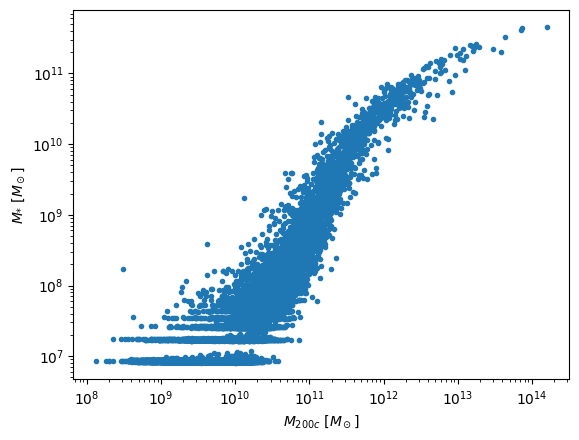

In [19]:
stellar_mass = soap.exclusive_sphere_50kpc.stellar_mass.to('Msun')
total_mass = soap.spherical_overdensity_200_crit.total_mass.to('Msun')
mask = (stellar_mass != 0) & (total_mass != 0)

plt.loglog(total_mass[mask], stellar_mass[mask], '.')
plt.xlabel(r'$M_{200c}$ [$M_\odot$]')
plt.ylabel(r'$M_{*}$ [$M_\odot$]')

### Pipeline plots

We produce a pipeline, which contains a large number of plots summarising the key properties of each simulation (e.g. the `z=0` pipeline of `L0050N0376/Fiducial_test` can be found [here](https://home.strw.leidenuniv.nl/~mcgibbon/COLIBRE/pipeline/L0050N0376_Thermal_non_equilibrium_2024August13_Mhs5e10Mbhs3e5/)).

If you would like a copy of any of the observational data in the pipeline then please send a request to a member of the COLIBRE team. All observational datasets are stored in a consistent format in an HDF5 file, which includes their units (stored in the dataset attributes). An example of an observational dataset is available in this repository.

In [20]:
with h5py.File('Hardwick2022_halfmass.hdf5', 'r') as file:
    print(f'File keys: {file.keys()}')
    # A description of the data is in the metadata
    for k, v in file['metadata'].attrs.items():
        print(f'{k}: {v}')
    # Data
    print(file['y'].keys())

File keys: <KeysViewHDF5 ['cosmology', 'metadata', 'x', 'y']>
bibcode: 2022MNRAS.509.3751H
citation: Hardwick et al. (2022) [half-mass]
comment: Galaxy stellar mass-size relation from the eXtended GALEX Arecibo SDSS Survey (xGASS) survey. Contains approximately 1200 galaxies in the redshift range 0.01 < z < 0.05 with a flat distribution of stellar masses between 10**9 and 10**11.5 Msun. Shows the median half-mass galaxy size in stellar mass bins of 0.2 dex.
name: Galaxy Stellar Mass-Galaxy Size
plot_as: points
redshift: 0.0
redshift_lower: 0.0
redshift_upper: 0.0
<KeysViewHDF5 ['scatter', 'values']>


Let's use some of the observational data to create a version of the [galaxy sizes plot](https://home.strw.leidenuniv.nl/~mcgibbon/COLIBRE/pipeline/L0050N0376_Thermal_non_equilibrium_2024August13_Mhs5e10Mbhs3e5/#8834710858053016908).

/cosma/apps/dp004/dc-mcgi1/venvs/test4/lib/python3.12/site-packages/swiftsimio/objects.py:273: RuntimeWarning: Mixing ufunc arguments with and without cosmo_factors, continuing assuming provided cosmo_factor (1 at a=0.9999999999999997) for all arguments.
  warnings.warn(


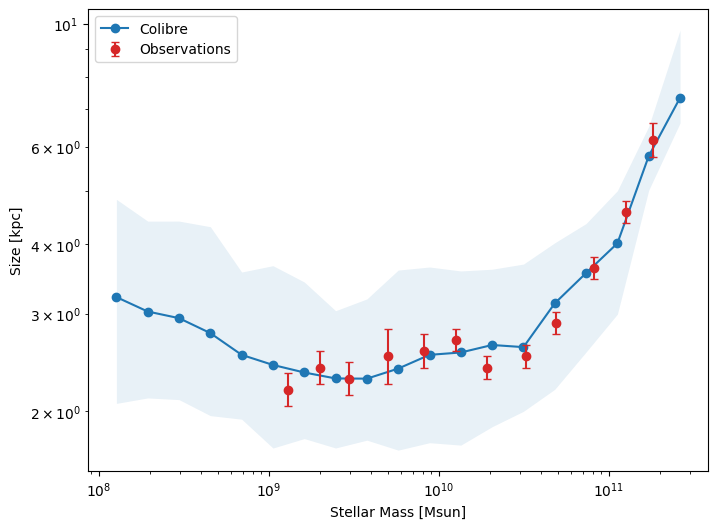

In [21]:
# Load the observational data, specify the units we want
with h5py.File('Hardwick2022_halfmass.hdf5', 'r') as file:
    obs_mass = file['x/values'][:] * unyt.Unit(file['x/values'].attrs['units'])
    obs_size = file['y/values'][:] * unyt.Unit(file['y/values'].attrs['units'])
    obs_size_scatter = file['y/scatter'][:] * unyt.Unit(file['y/scatter'].attrs['units'])
obs_mass = obs_mass.to('Msun')
obs_size = obs_size.to('kpc')
obs_size_scatter = obs_size_scatter.to('kpc')

# Load the simulation data, specifying the units we want
sim_mass = soap.exclusive_sphere_50kpc.stellar_mass.to('Msun')
sim_size = soap.projected_aperture_50kpc_projx.half_mass_radius_stars.to('kpc').to_physical()

# Define the number of bins for the simulation data
log_mass_bounds = [8, 11.5]
n_bins = 20
bins = (10 ** np.linspace(*log_mass_bounds, n_bins)) * unyt.Unit('Msun')
mids = (bins[1:] + bins[:-1]) / 2

# Bin the simulation data
median_sim_size = np.zeros(n_bins - 1)
lower_sim_size = np.zeros(n_bins - 1)
upper_sim_size = np.zeros(n_bins - 1)
for i in range(n_bins - 1):
    mask = (bins[i] <= sim_mass) & (sim_mass < bins[i + 1])
    if np.any(mask):  
        median_sim_size[i] = np.median(sim_size[mask].value)
        lower_sim_size[i] = np.percentile(sim_size[mask].value, 16)
        upper_sim_size[i] = np.percentile(sim_size[mask].value, 84)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(mids, median_sim_size, label='Colibre', marker='o', linestyle='-', color='tab:blue')
plt.fill_between(mids, lower_sim_size, upper_sim_size, color='tab:blue', alpha=0.1, linewidth=0)
plt.errorbar(obs_mass, obs_size, yerr=obs_size_scatter, label='Observations', fmt='o', color='tab:red', capsize=3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Stellar Mass [Msun]')
plt.ylabel('Size [kpc]')
plt.legend()

### Satellites and merger trees

HBT outputs merger tree information. Each subhalo in HBT is assigned a unique `TrackId` which remains consistent across all snapshots. The `TrackId` allows the quick retrieval of the main progenitor of a given subhalo. For example, the main progenitor of a `z = 0` subhalo with `TrackId = 10` corresponds to the subhalo whose `TrackId = 10` at earlier times. `TrackId` is stored in the SOAP catalogues in `data.input_halos_hbtplus.track_id`. Note that, due to SOAP not storing the information for subhaloes with `Nbound < 20` (e.g. disrupted, merged or poorly resolved), some `TrackIds` might be missing from the SOAP catalogues. In practice, this means there could be an object with `TrackId = 11` in the `z = 2` catalogue, but no object with `TrackId = 11` in the `z = 0` catalogue. Another result of this is that in order to construct full merger trees (outside of the main progenitor branch) you must use the HBT catalogues.

Let's load the most massive halo in the box at `z = 0`, and track it's evolution

In [34]:
simulation_dir = "/cosma8/data/dp004/colibre/Runs/L0025N0376/Fiducial_test"
snap_nr = 123   # z=0
soap_filename = f'{simulation_dir}/SOAP/halo_properties_{snap_nr:04}.hdf5'
soap = sw.load(soap_filename)

In [35]:
# Idenfity the TrackID of the galaxy with the largest stellar mass
stellar_mass = soap.exclusive_sphere_50kpc.stellar_mass
soap_idx = np.argmax(stellar_mass)
track_id = soap.input_halos_hbtplus.track_id[soap_idx]
# Grab the FOF ID while we're at it
fof_id = soap.input_halos_hbtplus.host_fofid[soap_idx].value
print(f'Most massive galaxy has TrackId={track_id.value}, FOF ID={fof_id}')

Most massive galaxy has TrackId=144, FOF ID=78954


In [24]:
snapshots = np.arange(43, 124, 10)
scale_factors = np.zeros(snapshots.shape[0])
dm_mass = np.zeros(snapshots.shape[0]) * unyt.Unit('Msun')
gas_mass = np.zeros(snapshots.shape[0]) * unyt.Unit('Msun')
stellar_mass = np.zeros(snapshots.shape[0]) * unyt.Unit('Msun')
for i, snap_nr in enumerate(snapshots):
    print('Loading snapshot', snap_nr)
    soap_filename = f'{simulation_dir}/SOAP/halo_properties_{snap_nr:04}.hdf5'
    soap = sw.load(soap_filename)
    scale_factors[i] = soap.metadata.a

    # Identify the location of the halo in this SOAP catalogue
    soap_idx = np.argmax(soap.input_halos_hbtplus.track_id[:].value == track_id)
    dm_mass[i] = soap.spherical_overdensity_200_crit.dark_matter_mass[soap_idx]
    gas_mass[i] = soap.spherical_overdensity_200_crit.gas_mass[soap_idx]
    stellar_mass[i] = soap.exclusive_sphere_50kpc.stellar_mass[soap_idx]

Loading snapshot 43
Loading snapshot 53
Loading snapshot 63
Loading snapshot 73
Loading snapshot 83
Loading snapshot 93
Loading snapshot 103
Loading snapshot 113
Loading snapshot 123


Text(0, 0.5, 'Mass [Msun]')

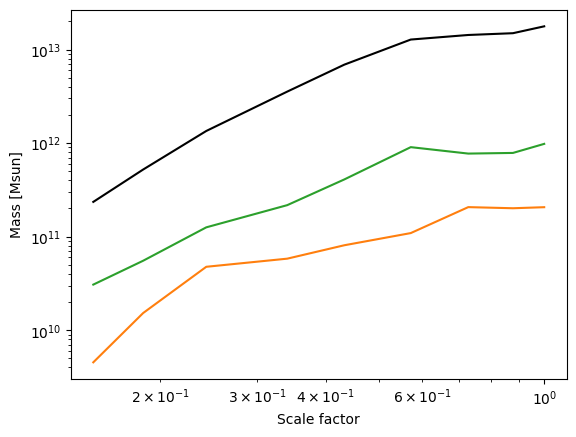

In [25]:
plt.plot(scale_factors, dm_mass, label='Dark matter', color='k')
plt.plot(scale_factors, gas_mass, label='Gas', color='tab:green')
plt.plot(scale_factors, stellar_mass, label='Stars', color='tab:orange')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Scale factor')
plt.ylabel('Mass [Msun]')

SOAP stores the host FOF ID of each subhalo, as well as whether an object is a central or satellite. HBT does have "hostless" halos, which correspond to splashback halos. Let's load all the satellites halos within the FOF of the most massive galaxy.

In [36]:
snap_nr = 123   # z=0
soap_filename = f'{simulation_dir}/SOAP/halo_properties_{snap_nr:04}.hdf5'
soap = sw.load(soap_filename)

In [38]:
# Load data, convert to mask
is_sat = (soap.input_halos.is_central[:].value == 0)
# Create mask of objects that share the same fof as the most massive object
in_fof = (soap.input_halos_hbtplus.host_fofid[:].value == fof_id)
# Combine masks to remove central
sat_in_fof = is_sat & in_fof

print(f'Fraction of satellites in total population: {np.sum(is_sat)/is_sat.shape[0]:.3g}')
print(f'Number of satellites in the FOF of the most massive galaxy: {np.sum(sat_in_fof)}')

# We can use this mask to load the properties of just the satellites we want
sat_stellar_mass = soap.exclusive_sphere_50kpc.stellar_mass[sat_in_fof]
sat_stellar_mass.to('Msun')

Fraction of satellites in total population: 0.233
Number of satellites in the FOF of the most massive galaxy: 2585


cosmo_array([4247575. ,       0. ,       0. , ...,       0. , 1035381.9,
             0. ], dtype=float32, units='Msun', comoving=False)

Each central subhalo stored in SOAP has the properties of it's host FOF subhalo available within `data.input_halos_hbtplus_fof`. FOF catalogues can also be loaded directly using swiftsimio. Let's load the masses of all FOF groups.

In [28]:
simulation_dir = "/cosma8/data/dp004/colibre/Runs/L0050N0376/Fiducial_test"
snap_nr = 127   # z=0
fof_filename = f'{simulation_dir}/fof/fof_output_{snap_nr:04}/fof_output_{snap_nr:04}.hdf5'
fof = sw.load(fof_filename)
fof.fof_groups.masses

cosmo_array([1.22805124e+04, 3.33678181e+03, 2.10459099e+03, ...,
       6.10679331e-02, 6.11025975e-02, 6.05705808e-02], '10000000000.0*Msun', comoving=True)

### Particle subhalo membership files

SOAP outputs membership files for each snapshot. These have the same structure and order as the SWIFT snapshots, and contain information about which subhalo each particle is bound to (if any). The `SOAP` directory of each simulation contains files named as `colibre_with_SOAP_membership_XXXX.hdf5`. These are virtual files which link the SWIFT snapshots with the membership files. If you load these files with swiftsimio you will have access to all the datasets (snapshots of memberships).  

In [29]:
simulation_dir = "/cosma8/data/dp004/colibre/Runs/L0050N0376/Fiducial_test"
snap_nr = 127   # z=0
snap_filename = f'{simulation_dir}/SOAP/colibre_with_SOAP_membership_{snap_nr:04}.hdf5'
snap = sw.load(snap_filename)

In [30]:
print('Open the masses:', snap.dark_matter.masses)
print('Open the subhalo membership:', snap.dark_matter.group_nr_bound)

Open the masses: [0.0019336  0.00193331 0.00192424 ... 0.00192838 0.00192208 0.00193075] 10000000000.0*Msun (Comoving)
Open the subhalo membership: [-1 -1 -1 ... -1 -1 -1] dimensionless (Comoving)


Note that the dataset `group_nr_bound` corresponds to value `soap.input_halos.halo_catalogue_index`, not directly to the index of the object in the SOAP catalogue. If you want to load the particles associated with a halo, you can use swiftsimo's masking feature to only load the particles in a region around the halo, and then use the membership data to constrain the bound particles. Alternatively,

# SWIFTgalaxy

[SWIFTGalaxy](https://swiftgalaxy.readthedocs.io/en/latest/) is a package built on top of swiftsimio that allows for easy loading an analysis of particles belonging to an individual galaxy. An example notebook can be found [here](https://nbviewer.org/github/SWIFTSIM/swiftgalaxy/blob/main/examples/SWIFTGalaxy_Colibre_QuickStart.ipynb).